In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import ee

In [2]:
ee.Initialize()

In [3]:
# Define region of interest
COORDs = [
 [-60.09384640, -33.11803785],
 [-56.61465669, -33.11803785],
 [-56.61465669, -35.91630163],
 [-60.09384640, -35.91630163]]

ROI = ee.Geometry.Polygon(COORDs)

ROI

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -60.0938464,
              -33.11803785
            ],
            [
              -56.61465669,
              -33.11803785
            ],
            [
              -56.61465669,
              -35.91630163
            ],
            [
              -60.0938464,
              -35.91630163
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [4]:
# Choose T0 simulation (so as to get todays data complete)

DATE_START = f"{datetime.strftime(datetime.now(), '%Y-%m-%d')}T00:00"
DATE_END = f"{datetime.strftime(datetime.now(), '%Y-%m-%d')}T06:00"

C_01 = ee.ImageCollection("NOAA/GFS0P25") \
                        .map(lambda image: image.clip(ROI)) \
                        .filterDate(DATE_START, DATE_END) \
                        .filterMetadata("forecast_hours", "greater_than", 0)

# Select band of interest
C_01 = C_01.select(["total_precipitation_surface"])

C_01

In [5]:
# Projection
PROJ = C_01.first().select(0).projection()

# Original scale
OS = C_01.first().projection().nominalScale().getInfo()

print(f"Original scale: {OS:.1f} m")

Original scale: 27799.7 m


In [6]:
# Turn into xarray dataset
DS_01 = xr.open_dataset(C_01, \
                        engine='ee',\
                        crs="EPSG:4326",\
                        projection=PROJ,\
                        geometry=ROI,\
                     )
DS_01

<xarray.Dataset>
Dimensions:                      (time: 208, lon: 14, lat: 11)
Coordinates:
  * time                         (time) datetime64[ns] 2024-08-01 ... 2024-08-01
  * lon                          (lon) float32 -59.97 -59.72 ... -56.97 -56.72
  * lat                          (lat) float32 -33.24 -33.49 ... -35.49 -35.74
Data variables:
    total_precipitation_surface  (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [7]:
# Rename variables
DS_01 = DS_01.rename({"total_precipitation_surface" : "PPT"})

DS_01

<xarray.Dataset>
Dimensions:  (time: 208, lon: 14, lat: 11)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-01 2024-08-01 ... 2024-08-01
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
Data variables:
    PPT      (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [8]:
# Filter first 120 registers
DS_01 = DS_01.isel(time=slice(0, 120))

DS_01

<xarray.Dataset>
Dimensions:  (time: 120, lon: 14, lat: 11)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-01 2024-08-01 ... 2024-08-01
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
Data variables:
    PPT      (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [9]:
FyH = pd.date_range(start=DATE_START, freq="1H", periods=120+1)[1:]

# Change timezone
FyH = FyH - pd.offsets.Hour(3)

DS_01 = DS_01.assign_coords(FyH=("time", FyH))

DS_01 = DS_01.swap_dims({"time" : "FyH"})
                            
DS_01 = DS_01.drop_vars("time")
    
DS_01

<xarray.Dataset>
Dimensions:  (FyH: 120, lon: 14, lat: 11)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-07-31T22:00:00 ... 2024-08-05T21:00:00
Data variables:
    PPT      (FyH, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [10]:
DS_01["FH"] = xr.DataArray(np.arange(1, 121), dims="FyH")

DS_01["H"] = DS_01["FH"] % 6

# Pulsos de ppt discreta
DS_01["PPT_D"] = DS_01["PPT"].diff(dim="FyH")

DS_01["PPT_D"] = DS_01["PPT_D"].where(DS_01["H"].shift(FyH=1) != 0, DS_01["PPT"])

DS_01

<xarray.Dataset>
Dimensions:  (lon: 14, lat: 11, FyH: 120)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-07-31T22:00:00 ... 2024-08-05T21:00:00
Data variables:
    PPT      (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FH       (FyH) int32 1 2 3 4 5 6 7 8 9 ... 113 114 115 116 117 118 119 120
    H        (FyH) int32 1 2 3 4 5 0 1 2 3 4 5 0 1 ... 0 1 2 3 4 5 0 1 2 3 4 5 0
    PPT_D    (FyH, lon, lat) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [11]:
# Calcular la ppt acumulada en c/ pixel

DS_01["CUMSUM"] = DS_01["PPT_D"].cumsum(dim="FyH")

DS_01

<xarray.Dataset>
Dimensions:  (lon: 14, lat: 11, FyH: 120)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-07-31T22:00:00 ... 2024-08-05T21:00:00
Data variables:
    PPT      (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FH       (FyH) int32 1 2 3 4 5 6 7 8 9 ... 113 114 115 116 117 118 119 120
    H        (FyH) int32 1 2 3 4 5 0 1 2 3 4 5 0 1 ... 0 1 2 3 4 5 0 1 2 3 4 5 0
    PPT_D    (FyH, lon, lat) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    CUMSUM   (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 ... 17.81 17.81 18.12 22.44
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [12]:
LON, LAT = -58.46633, -34.59960

DF_01 = DS_01.sel(lon=LON, lat=LAT, method="nearest").to_dataframe().drop(columns={"lon", "lat"})

DF_01

,PPT,FH,H,PPT_D,CUMSUM
FyH,,,,,
2024-07-31 22:00:00,0.0,1,1,NaN,0.000
2024-07-31 23:00:00,0.0,2,2,0.0,0.000
2024-08-01 00:00:00,0.0,3,3,0.0,0.000
2024-08-01 01:00:00,0.0,4,4,0.0,0.000
2024-08-01 02:00:00,0.0,5,5,0.0,0.000
...,...,...,...,...,...
2024-08-05 17:00:00,0.0,116,2,0.0,25.625
2024-08-05 18:00:00,0.0,117,3,0.0,25.625
2024-08-05 19:00:00,0.0,118,4,0.0,25.625


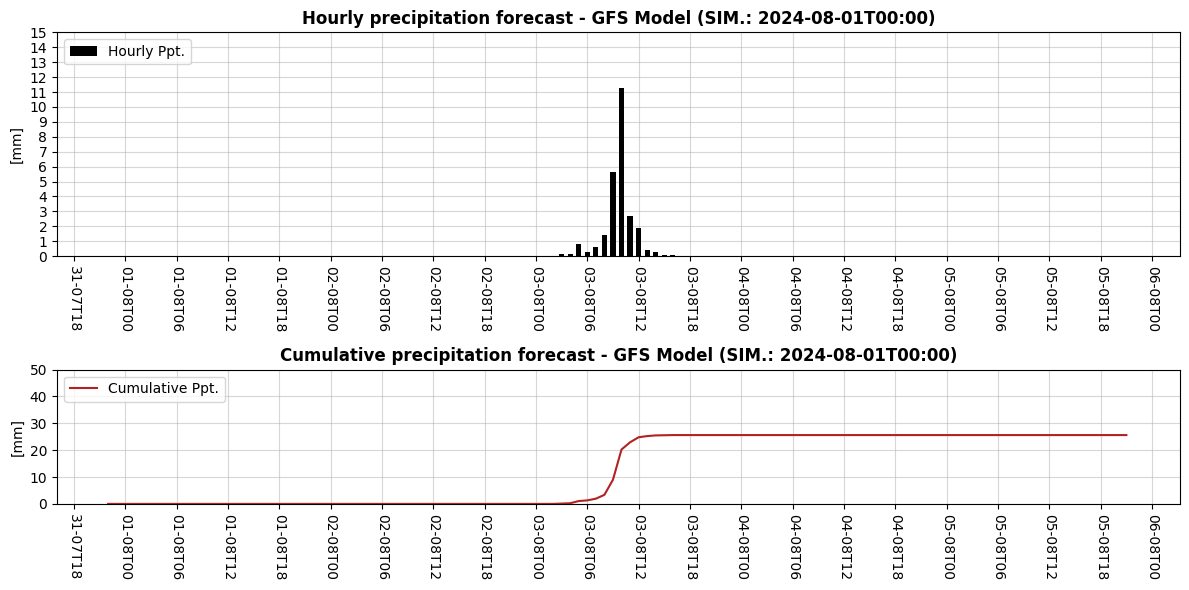

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios" : [1, .6]}, sharex=True)

ax[0].bar(DF_01.index, DF_01["PPT_D"], label="Hourly Ppt.", color="black", zorder=5, width=.025)
ax[0].set_title(f"Hourly precipitation forecast - GFS Model (SIM.: {DATE_START})", fontweight="bold")

# Set y range and ticks
ax[0].set_ylim(0, 15)
ax[0].yaxis.set_ticks(np.arange(0, 15+1, 1))

ax[1].plot(DF_01.index, DF_01["CUMSUM"], label="Cumulative Ppt.", color="firebrick", zorder=5)
ax[1].set_title(f"Cumulative precipitation forecast - GFS Model (SIM.: {DATE_START})", fontweight="bold")

# Set y range and ticks
ax[1].set_ylim(0, 50)
ax[1].yaxis.set_ticks(np.arange(0, 50+10, 10))

# Figure settings along both axis
for i in [0, 1]:

  ax[i].set_ylabel("[mm]")
  ax[i].legend(loc="upper left")
  ax[i].grid(alpha=.5)
  ax[i].tick_params(labelbottom=True)
  ax[i].tick_params(axis="both", which="major")
  DATE_FMT = mdates.DateFormatter('%d-%mT%H')
  ax[i].xaxis.set_major_formatter(DATE_FMT)
  ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
  ax[i].tick_params(axis="x", labelrotation=-90)

fig.tight_layout()
plt.show();